In [1]:
import pandas as pd
from collections import deque

df = pd.read_csv("../datasets/sample_livestock_data.csv")

df.head()

,goat_id,age,sex,weight_kg,milk_yield_l,temperature_c,previous_issues,last_breeding_date,parent_m,parent_f,health_flag
0,G001,3,F,38,1.8,39.4,1,2024-07-12,G010,G022,1
1,G002,2,F,33,1.4,38.7,0,2024-08-01,G015,G025,0
2,G003,5,M,45,0.0,39.8,1,2023-11-09,G007,G014,1
3,G004,1,F,28,0.9,38.5,0,2024-09-20,G003,G012,0
4,G005,4,F,41,1.7,39.1,1,2024-06-14,G011,G023,1


In [2]:
pedigree = {}

for _, row in df.iterrows():
    pid = row['goat_id']
    pedigree[pid] = [row['parent_m'], row['parent_f']]
    
pedigree

{'G001': ['G010', 'G022'],
 'G002': ['G015', 'G025'],
 'G003': ['G007', 'G014'],
 'G004': ['G003', 'G012'],
 'G005': ['G011', 'G023'],
 'G006': ['G019', 'G027'],
 'G007': ['G002', 'G018'],
 'G008': ['G013', 'G021'],
 'G009': ['G004', 'G020'],
 'G010': ['G009', 'G017'],
 'G011': ['G003', 'G014'],
 'G012': ['G010', 'G026'],
 'G013': ['G008', 'G019'],
 'G014': ['G001', 'G022'],
 'G015': ['G009', 'G024'],
 'G016': ['G011', 'G027'],
 'G017': ['G006', 'G013'],
 'G018': ['G010', 'G020'],
 'G019': ['G014', 'G025'],
 'G020': ['G007', 'G018']}

In [3]:
adj = {}

for goat, parents in pedigree.items():
    adj.setdefault(goat, set())
    for p in parents:
        if isinstance(p, str):     # ignore NaN or None
            adj.setdefault(p, set())
            adj[p].add(goat)
            adj[goat].add(p)

adj

{'G001': {'G010', 'G014', 'G022'},
 'G010': {'G001', 'G009', 'G012', 'G017', 'G018'},
 'G022': {'G001', 'G014'},
 'G002': {'G007', 'G015', 'G025'},
 'G015': {'G002', 'G009', 'G024'},
 'G025': {'G002', 'G019'},
 'G003': {'G004', 'G007', 'G011', 'G014'},
 'G007': {'G002', 'G003', 'G018', 'G020'},
 'G014': {'G001', 'G003', 'G011', 'G019', 'G022'},
 'G004': {'G003', 'G009', 'G012'},
 'G012': {'G004', 'G010', 'G026'},
 'G005': {'G011', 'G023'},
 'G011': {'G003', 'G005', 'G014', 'G016'},
 'G023': {'G005'},
 'G006': {'G017', 'G019', 'G027'},
 'G019': {'G006', 'G013', 'G014', 'G025'},
 'G027': {'G006', 'G016'},
 'G018': {'G007', 'G010', 'G020'},
 'G008': {'G013', 'G021'},
 'G013': {'G008', 'G017', 'G019'},
 'G021': {'G008'},
 'G009': {'G004', 'G010', 'G015', 'G020'},
 'G020': {'G007', 'G009', 'G018'},
 'G017': {'G006', 'G010', 'G013'},
 'G026': {'G012'},
 'G024': {'G015'},
 'G016': {'G011', 'G027'}}

In [4]:
def pedigree_distance(a, b, max_depth=6):
    """
    BFS to compute the shortest relationship distance.
    If distance > max_depth, return None.
    """
    if a == b:
        return 0
    
    visited = set([a])
    q = deque([(a, 0)])
    
    while q:
        node, dist = q.popleft()
        if node == b:
            return dist
        if dist >= max_depth:
            continue
        for nei in adj.get(node, []):
            if nei not in visited:
                visited.add(nei)
                q.append((nei, dist + 1))
    
    return None

In [5]:
def inbreeding_risk(dist):
    """
    Lower distance = more closely related = higher risk.
    
    dist = 1 → Parent-child or siblings → VERY HIGH risk  
    dist = 2 → HIGH  
    dist = 3 → MODERATE  
    dist >= 4 → LOW  
    None → UNKNOWN (treat as LOW)  
    """
    
    if dist is None:
        return 0.2   # low risk
    if dist == 0:
        return 1.0   # same goat
    if dist == 1:
        return 1.0
    if dist == 2:
        return 0.8
    if dist == 3:
        return 0.5
    if dist >= 4:
        return 0.2

In [6]:
def compatibility_score(goat_a, goat_b):
    row_a = df[df['goat_id'] == goat_a].iloc[0]
    row_b = df[df['goat_id'] == goat_b].iloc[0]
    
    # 1. Pedigree distance → inbreeding penalty
    dist = pedigree_distance(goat_a, goat_b)
    risk = inbreeding_risk(dist)
    
    # 2. Age compatibility (ideal age difference < 3 years)
    age_diff = abs(row_a['age'] - row_b['age'])
    age_score = 1.0 if age_diff <= 3 else 0.5
    
    # 3. Health (0 healthy, 1 needs attention)
    health_a = 1 - row_a['health_flag']
    health_b = 1 - row_b['health_flag']
    health_score = (health_a + health_b) / 2
    
    # FINAL SCORE: higher is better
    score = (0.5 * age_score) + (0.3 * health_score) + (0.2 * (1 - risk))
    
    return score, dist, risk

In [7]:
def recommend_matches(goat_id, top_k=5):
    candidates = df[df['goat_id'] != goat_id]['goat_id'].tolist()
    
    results = []
    
    for c in candidates:
        score, dist, risk = compatibility_score(goat_id, c)
        results.append({
            "candidate": c,
            "score": round(score, 3),
            "pedigree_distance": dist,
            "inbreeding_risk": round(risk, 3)
        })
    
    # Sort by highest compatibility score
    results = sorted(results, key=lambda x: x['score'], reverse=True)
    
    return results[:top_k]

C:\Users\amrit\AppData\Local\Temp\ipykernel_30372\1793812154.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_recs, x="candidate", y="score", palette="viridis")


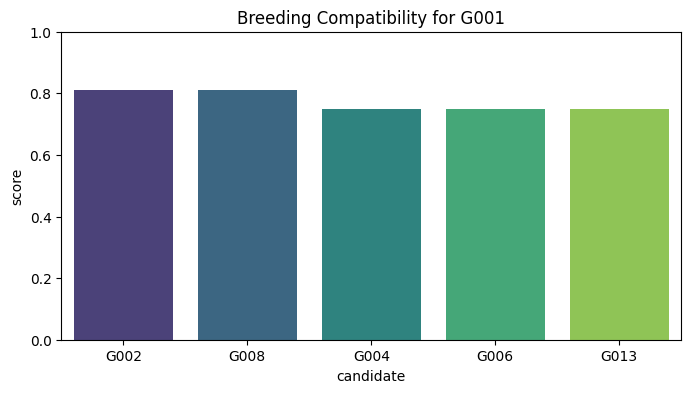

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scores(goat_id, top_k=5):
    df_recs = show_recommendations(goat_id, top_k)
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_recs, x="candidate", y="score", palette="viridis")
    plt.title(f"Breeding Compatibility for {goat_id}")
    plt.ylim(0,1)
    plt.show()

plot_scores("G001", 5)

In [9]:
import pickle

pickle.dump({
    "pedigree": pedigree,
    "adj": adj,
}, open("../models/breeding_graph.pkl", "wb"))